<a href="https://colab.research.google.com/github/aleksmirosh/Big-Data-School/blob/main/Capstone_Project_Clusterization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Instalations

In [2]:
!pip install geopandas

     |████████████████████████████████| 972kB 11.2MB/s 
     |████████████████████████████████| 14.8MB 295kB/s 
     |████████████████████████████████| 6.5MB 43.4MB/s 


In [3]:
!pip install shapely

In [4]:
import geopy.distance
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas
import numpy as np
import datetime as dt
from shapely.geometry import Point, Polygon

In [5]:
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# install findspark 
!pip install -q findspark

In [6]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [7]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [8]:
# Check the pyspark version
import pyspark
print(pyspark.__version__)

3.0.0


In [9]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import geopy.distance

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from sklearn.model_selection import StratifiedKFold

import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Task 1 - Clusterization users upon their routes in 2019

As a part of a team I created features for future data visualization and clusterization.

### Create Features

**Districts Data Set**

In [ ]:
districts_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lviv/districts_info.csv.gz', sep='|', dtype={'area_id':'int'})
small_district = districts_df.copy().drop(['region_name',	'area_name', 'neighbor_area_idx'], axis = 1)
print(districts_df.shape)
districts_df.head()

(536, 6)


,area_id,region_name,area_name,centroid_lat,centroid_lon,neighbor_area_idx
0,504,Ivano-Frankivska,Nadvirnianskyi raion,48.629834,24.577387,"""[\""529\"", \""473\"", \""505\"", \""437\"", \""506\"",..."
1,505,Ivano-Frankivska,Bohorodchanskyi raion,48.807555,24.543633,"""[\""473\"", \""504\"", \""503\"", \""509\"", \""531\""]"""
2,506,Ivano-Frankivska,Yaremchanska mis'ka rada,48.455939,24.569405,"""[\""471\"", \""504\"", \""437\"", \""510\""]"""
3,507,Ivano-Frankivska,Ivano-Frankivska mis'ka rada,48.917401,24.710827,"""[\""473\""]"""
4,508,Zaporizka,Zaporizka mis'ka rada,47.845421,35.160531,"""[\""459\"", \""461\""]"""


In [ ]:
#clean neighbor_area_idx column
districts_df['neighbor_area_idx'] = districts_df['neighbor_area_idx'].str.findall('[0-9]+')

#convert last column to list
districts_df['neighbor_area_idx'] = districts_df['neighbor_area_idx'].apply(lambda x: [int(i) for i in x])

#convert last columns from list to array
districts_df['neighbor_area_idx'] = districts_df['neighbor_area_idx'].apply(lambda x: np.array(x))

**User Routes 2019, 2020**

contains data on subscribers routes between areas in 2019 and 2020. Moving means that the subscriber before the start of the trip and at the end of the trip was in acc. area more than 3 hours.


In [ ]:
#full user routes dataframe
user_routes_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lviv/user_routes_2019_2020.csv.gz', parse_dates = [4,5], dtype={'start_area_id':'int', 'finish_area_id':'int'})
print(user_routes_df.shape)     
user_routes_df.head()

(6997282, 6)


,user_id,start_area_id,finish_area_id,start_time,finish_time,hmonth
0,36453,492,417,2020-08-11 15:00:00,2020-08-11 16:00:00,2020-08-01
1,42921,492,417,2020-09-01 22:00:00,2020-09-01 23:00:00,2020-09-01
2,17307,526,435,2020-06-07 10:00:00,2020-06-07 13:00:00,2020-06-01
3,24129,416,49,2019-04-21 19:00:00,2019-04-21 20:00:00,2019-04-01
4,10139,540,539,2020-05-01 06:00:00,2020-05-01 07:00:00,2020-05-01


In [ ]:
#2019 year only 
user_routes_2019 = user_routes_df.loc[user_routes_df.hmonth < '2020']

#2020 year only 
user_routes_2020 = user_routes_df.loc[user_routes_df.hmonth > '2019-12']

In [ ]:
user_routes_2019.shape

(3650287, 7)

**User_routes data set conteins more then 3m examples, google colab can not work with it on python, that's why next manipulations were in pyspark.**

In [ ]:
# do not re-run
def tospark(df):
  #convert pandas to pyspark
  temp = spark.createDataFrame(df[['user_id','start_time']])

  #define the new columns with leading start time
  windowSpec = Window.partitionBy("user_id").orderBy('start_time')
  temp = temp.withColumn('next_start_time', lead('start_time', 1).over(windowSpec))

  #save temp dataframe
  temp.toPandas().to_csv('/content/drive/MyDrive/Colab Notebooks/lviv/temp.csv')
  del temp

tospark(user_routes_2019)

In [ ]:
#read temp df
temp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lviv/temp.csv').drop('Unnamed: 0', axis = 1)

#merge dataframes
user_routes_2019 = user_routes_2019.merge(temp, on = ['user_id', 'start_time'])\
                                    .sort_values(['user_id', 'start_time'])

**Next I find time difference between user's start-finish time and finish-start time, also what the day of the week it was: weekday or weekand**

In [ ]:
def time_diff(df):
  #converting str columns to datetime
  df['start_time'] = df['start_time'].astype('datetime64')
  df['next_start_time'] = df['next_start_time'].astype('datetime64')

  #adding new column with time difference between start and finish time
  df['diff_start_finish'] = df['finish_time'] - df['start_time']

  #adding new column with time difference between finish and next start time
  df['diff_finish_next_start'] = df['next_start_time'] - df['finish_time']

  #drop unnessecary columns
  df.drop('next_start_time', axis = 1, inplace = True)

  #days of week
  df['day'] = df['start_time'].dt.dayofweek.map({0: 'weekday', 1: 'weekday', 2: 'weekday', 3: 'weekday', 4: 'weekday', 5: 'weekend', 6: 'weekend'})

  return df

In [ ]:
user_routes_2019 = time_diff(user_routes_2019)

In [ ]:
user_routes_2019

,user_id,start_area_id,finish_area_id,start_time,finish_time,hmonth,diff_start_finish,diff_finish_next_start,day
2922433,1,505,507,2019-04-01 08:00:00,2019-04-01 09:00:00,2019-04-01,0 days 01:00:00,0 days 10:00:00,weekday
1885447,1,507,504,2019-04-01 19:00:00,2019-04-01 20:00:00,2019-04-01,0 days 01:00:00,0 days 11:00:00,weekday
1842128,1,504,505,2019-04-02 07:00:00,2019-04-02 08:00:00,2019-04-01,0 days 01:00:00,1 days 22:00:00,weekday
3625775,1,505,507,2019-04-04 06:00:00,2019-04-04 08:00:00,2019-04-01,0 days 02:00:00,0 days 12:00:00,weekday
635475,1,507,505,2019-04-04 20:00:00,2019-04-04 21:00:00,2019-04-01,0 days 01:00:00,0 days 09:00:00,weekday
...,...,...,...,...,...,...,...,...,...
3045293,50000,492,179,2019-08-14 08:00:00,2019-08-14 12:00:00,2019-08-01,0 days 04:00:00,12 days 19:00:00,weekday
2367610,50000,179,228,2019-08-27 07:00:00,2019-08-27 09:00:00,2019-08-01,0 days 02:00:00,0 days 06:00:00,weekday
445058,50000,228,179,2019-08-27 15:00:00,2019-08-27 18:00:00,2019-08-01,0 days 03:00:00,1 days 12:00:00,weekday
801298,50000,179,492,2019-08-29 06:00:00,2019-08-29 10:00:00,2019-08-01,0 days 04:00:00,5 days 06:00:00,weekday


**Next using Vincenty formula I calculate distance between areas user visited**

In [ ]:
#distance between areas
from geopy.distance import vincenty
def dist(lat1, lon1, lat2, lon2):
  ans = vincenty([lat1, lon1], [lat2, lon2]).km
  return ans

def distance(df):
  df = df.merge(small_district, right_on = 'area_id', left_on = 'start_area_id', suffixes = ['_1', '_2']).drop('area_id', axis = 1)
  df = df.merge(small_district, right_on = 'area_id', left_on = 'finish_area_id', suffixes = ['_1', '_2']).drop('area_id', axis = 1)

  df['distance'] = df[['centroid_lat_1',	'centroid_lon_1',	'centroid_lat_2',	'centroid_lon_2']]\
                              .apply(lambda row: dist(row['centroid_lat_1'],row['centroid_lon_1'],row['centroid_lat_2'],row['centroid_lon_2']),axis=1) 

  df.drop(['centroid_lat_1', 'centroid_lon_1', 'centroid_lat_2', 'centroid_lon_2'], axis = 1, inplace = True)        
  
  return df

In [ ]:
user_routes_2019 = distance(user_routes_2019)

In [ ]:
user_routes_2019

,user_id,start_area_id,finish_area_id,start_time,finish_time,hmonth,diff_start_finish,diff_finish_next_start,day,distance
0,1,505,507,2019-04-01 08:00:00,2019-04-01 09:00:00,2019-04-01,0 days 01:00:00,0 days 10:00:00,weekday,17.312255
1,1,505,507,2019-04-04 06:00:00,2019-04-04 08:00:00,2019-04-01,0 days 02:00:00,0 days 12:00:00,weekday,17.312255
2,1,505,507,2019-04-05 06:00:00,2019-04-05 07:00:00,2019-04-01,0 days 01:00:00,0 days 13:00:00,weekday,17.312255
3,1,505,507,2019-04-09 06:00:00,2019-04-09 07:00:00,2019-04-01,0 days 01:00:00,0 days 13:00:00,weekday,17.312255
4,1,505,507,2019-04-12 06:00:00,2019-04-12 08:00:00,2019-04-01,0 days 02:00:00,0 days 11:00:00,weekday,17.312255
...,...,...,...,...,...,...,...,...,...,...
3650060,44139,487,485,2019-06-19 08:00:00,2019-06-19 09:00:00,2019-06-01,0 days 01:00:00,3 days 02:00:00,weekday,34.722499
3650061,44139,487,485,2019-06-30 10:00:00,2019-06-30 11:00:00,2019-06-01,0 days 01:00:00,57 days 01:00:00,weekend,34.722499
3650062,44139,487,485,2019-08-29 12:00:00,2019-08-29 13:00:00,2019-08-01,0 days 01:00:00,29 days 00:00:00,weekday,34.722499
3650063,44139,487,485,2019-09-30 10:00:00,2019-09-30 11:00:00,2019-09-01,0 days 01:00:00,NaT,weekday,34.722499


In [ ]:
#convert time to integer
user_routes_2019['diff_start_finish'] = user_routes_2019.diff_start_finish.astype('int64')

#statistics per weekdays
weekdays_df = user_routes_2019.loc[(user_routes_2019['day'] == 'weekday')]\
                .groupby('user_id').agg({'diff_start_finish':'mean', 'distance':'mean', 'start_time':'count'})

#statistics per weekends
weekends_df = user_routes_2019.loc[(user_routes_2019['day'] == 'weekend')]\
                .groupby('user_id').agg({'diff_start_finish':'mean', 'distance':'mean', 'start_time':'count'})

In [ ]:
weekdays_df 

,diff_start_finish,distance,start_time
user_id,,,
1,4.133333e+12,22.818568,135
2,4.685714e+12,30.407771,63
3,5.552113e+12,25.720384,142
4,4.153846e+12,113.689730,39
5,3.744000e+12,22.662927,50
...,...,...,...
49996,4.430769e+12,20.559820,13
49997,4.200000e+12,27.896989,18
49998,4.320000e+12,98.335410,5


**Count trips**

It sounds like a good idea - to have number of trips for each user per month and per day, so it would help with some statictics.

In [ ]:
def count_trips(df, year):
  #for all time
  temp = df.groupby('user_id')[['start_time']].agg('count')
  temp.to_csv('/content/drive/MyDrive/Colab Notebooks/lviv/final/count_trip_all_{}.csv'.format(year))

  #per month
  temp = df.groupby(['user_id',df['hmonth'].dt.month])[['start_time']].agg('count')
  temp.to_csv('/content/drive/MyDrive/Colab Notebooks/lviv/final/count_trip_month_{}.csv'.format(year))

  #per day
  temp = df.groupby(['user_id',df['start_time'].dt.day])[['finish_time']].agg('count')
  temp.to_csv('/content/drive/MyDrive/Colab Notebooks/lviv/final/count_trip_day_{}.csv'.format(year))

In [ ]:
count_trips(user_routes_2019, '2019')

**Day/Night Activity**

I divided a day to four zone upon working routine - morning(6:00-10:00), day(10:00-16:00), ev(16:00-20:00), night(20:00-06:00).

In [ ]:
import datetime as dt

In [ ]:
user_routes_2019['time'] = user_routes_2019['finish_time'].dt.time

In [ ]:
six_h = dt.datetime.strptime('06:00:00', '%H:%M:%S').time()
ten_h = dt.datetime.strptime('10:00:00', '%H:%M:%S').time()
four_h = dt.datetime.strptime('16:00:00', '%H:%M:%S').time()
eight_h = dt.datetime.strptime('20:00:00', '%H:%M:%S').time()

In [ ]:
user_routes_2019['time_of_day'] = user_routes_2019['time'].apply(lambda x: 0 if (x >= six_h)&(x <= ten_h) else (1 if (x > ten_h)&(x <= four_h) else (2 if (x > four_h)&(x <= eight_h) else 3)))

In [ ]:
user_routes_2019['time_of_day'].value_counts()

1    1185054
0    1037296
2     907534
3     520181
Name: time_of_day, dtype: int64

In [ ]:
user_routes_2019

,user_id,start_area_id,finish_area_id,start_time,finish_time,hmonth,diff_start_finish,diff_finish_next_start,day,distance,time,time_of_day
0,1,505,507,2019-04-01 08:00:00,2019-04-01 09:00:00,2019-04-01,3600000000000,0 days 10:00:00,weekday,17.312255,09:00:00,0
1,1,505,507,2019-04-04 06:00:00,2019-04-04 08:00:00,2019-04-01,7200000000000,0 days 12:00:00,weekday,17.312255,08:00:00,0
2,1,505,507,2019-04-05 06:00:00,2019-04-05 07:00:00,2019-04-01,3600000000000,0 days 13:00:00,weekday,17.312255,07:00:00,0
3,1,505,507,2019-04-09 06:00:00,2019-04-09 07:00:00,2019-04-01,3600000000000,0 days 13:00:00,weekday,17.312255,07:00:00,0
4,1,505,507,2019-04-12 06:00:00,2019-04-12 08:00:00,2019-04-01,7200000000000,0 days 11:00:00,weekday,17.312255,08:00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3650060,44139,487,485,2019-06-19 08:00:00,2019-06-19 09:00:00,2019-06-01,3600000000000,3 days 02:00:00,weekday,34.722499,09:00:00,0
3650061,44139,487,485,2019-06-30 10:00:00,2019-06-30 11:00:00,2019-06-01,3600000000000,57 days 01:00:00,weekend,34.722499,11:00:00,1
3650062,44139,487,485,2019-08-29 12:00:00,2019-08-29 13:00:00,2019-08-01,3600000000000,29 days 00:00:00,weekday,34.722499,13:00:00,1
3650063,44139,487,485,2019-09-30 10:00:00,2019-09-30 11:00:00,2019-09-01,3600000000000,NaT,weekday,34.722499,11:00:00,1


**Gather everything to one dataframe**

In [ ]:
user_day_time = user_routes_2019.merge(districts_df, right_on = 'area_id', left_on = 'finish_area_id').drop('area_id', axis = 1)
user_day_time.head()

,user_id,start_area_id,finish_area_id,start_time,finish_time,hmonth,diff_start_finish,diff_finish_next_start,day,distance,time,time_of_day,region_name,area_name,centroid_lat,centroid_lon,neighbor_area_idx
0,1,505,507,2019-04-01 08:00:00,2019-04-01 09:00:00,2019-04-01,3600000000000,0 days 10:00:00,weekday,17.312255,09:00:00,0,Ivano-Frankivska,Ivano-Frankivska mis'ka rada,48.917401,24.710827,[473]
1,1,505,507,2019-04-04 06:00:00,2019-04-04 08:00:00,2019-04-01,7200000000000,0 days 12:00:00,weekday,17.312255,08:00:00,0,Ivano-Frankivska,Ivano-Frankivska mis'ka rada,48.917401,24.710827,[473]
2,1,505,507,2019-04-05 06:00:00,2019-04-05 07:00:00,2019-04-01,3600000000000,0 days 13:00:00,weekday,17.312255,07:00:00,0,Ivano-Frankivska,Ivano-Frankivska mis'ka rada,48.917401,24.710827,[473]
3,1,505,507,2019-04-09 06:00:00,2019-04-09 07:00:00,2019-04-01,3600000000000,0 days 13:00:00,weekday,17.312255,07:00:00,0,Ivano-Frankivska,Ivano-Frankivska mis'ka rada,48.917401,24.710827,[473]
4,1,505,507,2019-04-12 06:00:00,2019-04-12 08:00:00,2019-04-01,7200000000000,0 days 11:00:00,weekday,17.312255,08:00:00,0,Ivano-Frankivska,Ivano-Frankivska mis'ka rada,48.917401,24.710827,[473]


**Pivot table to see distance per daytime and day of the week and the number of trips.**

In [ ]:
pivot_table_2019 = user_day_time.pivot_table(index = 'user_id', columns = ['day','time_of_day'], aggfunc={'distance':'mean', 'start_time':'count'})

pivot_table_2019.columns = pivot_table_2019.columns.droplevel([0,1])
pivot_table_2019.columns = ['0_dist_weekday','1_dist_weekday','2_dist_weekday','3_dist_weekday',
                              '0_dist_weekend','1_dist_weekend','2_dist_weekend','3_dist_weekend',
                              '0_count_weekday','1_count_weekday','2_count_weekday','3_count_weekday',
                              '0_count_weekend','1_count_weekend','2_count_weekend','3_count_weekend']
#pivot_table_2019.to_csv('/content/drive/MyDrive/Colab Notebooks/lviv/final/pivot_2019.csv')

In [ ]:
pivot_table_2019

,0_dist_weekday,1_dist_weekday,2_dist_weekday,3_dist_weekday,0_dist_weekend,1_dist_weekend,2_dist_weekend,3_dist_weekend,0_count_weekday,1_count_weekday,2_count_weekday,3_count_weekday,0_count_weekend,1_count_weekend,2_count_weekend,3_count_weekend
user_id,,,,,,,,,,,,,,,,
1,20.311198,22.260407,27.123348,25.248549,20.585974,52.796969,24.254330,21.350247,63.0,22.0,26.0,24.0,26.0,3.0,11.0,15.0
2,24.920316,34.471080,39.215212,27.552472,23.384891,33.273242,26.361735,34.144706,19.0,13.0,12.0,19.0,4.0,6.0,7.0,9.0
3,27.814873,26.941040,22.360293,18.463876,28.647317,38.972378,91.539834,11.889746,52.0,55.0,20.0,15.0,16.0,24.0,7.0,4.0
4,109.833090,154.860980,72.882096,15.664343,154.167324,94.112215,7.346794,NaN,10.0,17.0,9.0,3.0,2.0,6.0,2.0,NaN
5,22.662927,22.662927,22.662927,22.662927,22.662927,22.662927,22.662927,22.662927,10.0,25.0,13.0,2.0,5.0,9.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49996,43.755871,6.062287,6.062287,NaN,6.062287,6.062287,194.530207,NaN,5.0,7.0,1.0,NaN,1.0,1.0,1.0,NaN
49997,29.699965,26.454607,NaN,NaN,13.473174,NaN,13.473174,NaN,8.0,10.0,NaN,NaN,1.0,NaN,1.0,NaN
49998,59.896251,82.238946,207.406657,NaN,84.628500,7.346794,NaN,NaN,2.0,2.0,1.0,NaN,2.0,3.0,NaN,NaN


In [ ]:
user_day_time_grouped = user_day_time.groupby(['user_id', 'day', 'time_of_day']).agg({'start_area_id':'count', 'distance':['min', 'mean', 'max'], 'finish_area_id':lambda x: set(x)})

In [ ]:
user_day_time_grouped.columns = user_day_time_grouped.columns.droplevel(0)
user_day_time_grouped.rename({'count':'count_trips', 'min': 'min_distance', 'mean':'mean_distance', 'max':'max_distance', '<lambda>':'final_areas'}, axis = 1, inplace = True)

In [ ]:
#user_day_time_grouped.to_csv('/content/drive/MyDrive/Colab Notebooks/lviv/final/full_2019.csv')

In [ ]:
user_day_time_grouped

count_trips  ...           final_areas
user_id day     time_of_day               ...                      
1       weekday 0                     63  ...  {504, 473, 507, 505}
                1                     22  ...            {504, 505}
                2                     26  ...            {504, 505}
                3                     24  ...       {504, 473, 505}
        weekend 0                     26  ...       {504, 505, 507}
...                                  ...  ...                   ...
50000   weekday 0                      7  ...            {228, 492}
                1                      1  ...                 {179}
                2                      4  ...                 {179}
                3                      1  ...                 {179}
        weekend 1                      1  ...                 {179}

[352013 rows x 5 columns]

**Users living area**

I define the area where the user may live, its frequency in his routes, region and neighbour areas

In [ ]:
#adding mode and frequancy for start area
from scipy.stats import mode

def living_area(df):
  temp_df = df\
          .groupby('user_id', as_index=False)[['start_area_id']]\
          .agg(mode)

  #separete columns
  temp_df['area_freq'] = temp_df['start_area_id'].apply(lambda x: x[1][0])
  temp_df['start_area_id'] = temp_df['start_area_id'].apply(lambda x: x[0][0])

  temp_df = temp_df.merge(districts_df, right_on = 'area_id', left_on = 'start_area_id').drop('area_id', axis = 1)
  temp_df = temp_df.rename({'start_area_id':'living_area'}, axis = 1).drop('area_name', axis = 1)

  return temp_df

In [ ]:
user_living_area = living_area(user_routes_2019)

In [ ]:
user_living_area.head()

,user_id,living_area,area_freq,region_name,centroid_lat,centroid_lon,neighbor_area_idx
0,1,505,70,Ivano-Frankivska,48.807555,24.543633,"[473, 504, 503, 509, 531]"
1,500,505,10,Ivano-Frankivska,48.807555,24.543633,"[473, 504, 503, 509, 531]"
2,1798,505,20,Ivano-Frankivska,48.807555,24.543633,"[473, 504, 503, 509, 531]"
3,1844,505,14,Ivano-Frankivska,48.807555,24.543633,"[473, 504, 503, 509, 531]"
4,2112,505,18,Ivano-Frankivska,48.807555,24.543633,"[473, 504, 503, 509, 531]"


**Popular trips per weekdays and weekends**

I find most popular areas per weekdays and weekends for each user

In [ ]:
def popular_trips_weekdays(df):
  #weekdays
  weekdays_exp = (df['day'] == 'weekday')

  #count area frequency per weekdays
  weekdays_temp = df.loc[weekdays_exp]\
                .groupby('user_id')['start_area_id'].value_counts()\
                .to_frame().rename({'start_area_id':'count'}, axis = 1)

  #select 3 most frequency area per weekdays
  weekdays_temp = weekdays_temp.groupby('user_id').head(3).reset_index().groupby('user_id')['start_area_id'].apply(list)

  return weekdays_temp

In [ ]:
def popular_trips_weekends(df):
  #weekends
  weekends_exp = (df['day'] == 'weekend')

  #count area frequency per weekends
  weekends_temp = df.loc[weekends_exp]\
                .groupby('user_id')['start_area_id'].value_counts()\
                .to_frame().rename({'start_area_id':'count'}, axis = 1)

  #select 3 most frequency area per weekends
  weekends_temp = weekends_temp.groupby('user_id').head(3).reset_index().groupby('user_id')['start_area_id'].apply(list)

  return weekends_temp

In [ ]:
user_living_area = user_living_area.merge(popular_trips_weekdays(user_routes_2019), right_index = True, left_on = 'user_id')\
                .rename({'start_area_id':'areas_weekdays'}, axis = 1)

user_living_area = user_living_area.merge(popular_trips_weekends(user_routes_2019), right_index = True, left_on = 'user_id')\
                .rename({'start_area_id':'areas_weekends'}, axis = 1)

In [ ]:
user_living_area = user_living_area.merge(weekdays_df, right_index = True, left_on = 'user_id').rename({'diff_start_finish':'mean_time_weekdays', 'distance':'mean_dist_weekdays', 'start_time':'count_trips_weekdays'}, axis = 1)
user_stat_2019 = user_living_area.merge(weekends_df, right_index = True, left_on = 'user_id').rename({'diff_start_finish':'mean_time_weekends', 'distance':'mean_dist_weekends', 'start_time':'count_trips_weekends'}, axis = 1)

In [ ]:
#user_stat_2019.to_csv('/content/drive/MyDrive/Colab Notebooks/lviv/final/user_stat_2019.csv')

In [ ]:
user_stat_2019

,user_id,living_area,area_freq,region_name,centroid_lat,centroid_lon,neighbor_area_idx,areas_weekdays,areas_weekends,mean_time_weekdays,mean_dist_weekdays,count_trips_weekdays,mean_time_weekends,mean_dist_weekends,count_trips_weekends
0,1,505,70,Ivano-Frankivska,48.807555,24.543633,"[473, 504, 503, 509, 531]","[505, 507, 504]","[505, 507, 504]",4.133333e+12,22.818568,135,4.581818e+12,23.285047,55
1,500,505,10,Ivano-Frankivska,48.807555,24.543633,"[473, 504, 503, 509, 531]","[354, 505, 492]","[505, 507, 336]",7.200000e+12,219.874633,53,3.600000e+12,27.523671,8
2,1798,505,20,Ivano-Frankivska,48.807555,24.543633,"[473, 504, 503, 509, 531]","[505, 473, 507]","[505, 473, 440]",4.296774e+12,21.221287,31,4.320000e+12,25.245205,10
3,1844,505,14,Ivano-Frankivska,48.807555,24.543633,"[473, 504, 503, 509, 531]","[505, 473, 507]","[505, 473, 482]",6.533333e+12,39.430642,27,7.800000e+12,47.609919,6
4,2112,505,18,Ivano-Frankivska,48.807555,24.543633,"[473, 504, 503, 509, 531]","[505, 507, 482]","[505, 507]",5.250000e+12,28.339603,24,3.900000e+12,17.312255,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,30927,139,11,Odeska,47.540147,29.461138,"[244, 129]","[139, 244, 132]","[139, 232, 244]",5.040000e+12,42.669040,20,3.600000e+12,54.270395,4
49996,34562,139,4,Odeska,47.540147,29.461138,"[244, 129]","[139, 1, 80]","[139, 232, 244]",7.920000e+12,82.064401,5,7.200000e+12,88.030147,4
49997,49153,139,6,Odeska,47.540147,29.461138,"[244, 129]","[139, 140, 243]","[243, 139, 244]",3.600000e+12,45.759428,6,3.600000e+12,40.292992,8
49998,28400,321,11,Kharkivska,49.380325,37.624960,"[386, 342, 490, 533, 380, 381]","[321, 364, 380]","[321, 364, 380]",3.600000e+12,63.335253,19,3.600000e+12,61.137614,7


### **Final Features for clusterization:**
 - living area
 - most popular areas on weekdays
 - most popular areas on weekends
 - mean time spent for routes on weekdays
 - mean distance user went on weekdays
 - number of trips on weekdays
 - mean time spent for routes on weekends
 - mean distance user went on weekends
 - number of trips on weekends



## Task 2 - Clusterization users who visited Lviv on September in 2019

Using user routes data in Lviv find how they arrived to the city and left it. Also create clusterization for purpose of visiting the city.

I created features, visualizations and clusterization for this task alone as the rest of a team worked on the complex first task

### Explotatory Analysis

**Lviv shape - define the city borders.**

In [39]:
import json
import re
sns.set()

path = '/content/drive/MyDrive/Colab Notebooks/lviv/Lviv.geojson'
with open(path) as f:
    geojson = json.load(f)

In [40]:
geojson = re.findall(r"(\d*.\d*,\d*.\d*\])", geojson)
geojson = pd.DataFrame(geojson).rename({0: "data"}, axis='columns')
geojson = geojson['data'].str.split(",", n = 1, expand = True)\
                        .rename({0: "lat", 1:'lon'}, axis='columns')\
                        .dropna()\
                        .astype({'lat': 'float'})
geojson['lon'] = geojson['lon'].str.rstrip('],').astype('float')
geojson.head()

,lat,lon
0,24.100619,49.848169
1,24.100500,49.847624
2,24.100476,49.847512
3,24.100475,49.847427
4,24.100481,49.847392


In [41]:
geo_df = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(geojson.lat, geojson.lon))

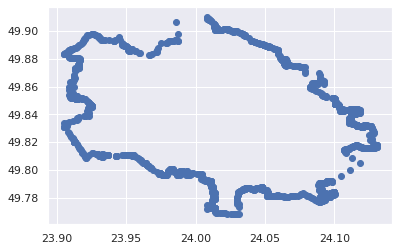

In [42]:
geo_df.plot(figsize=(12, 4))

In [43]:
#select first 500k point for visualization user transactions who visited Lviv in September
points = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(transactions.lat[:500000], transactions.lon[:500000]))

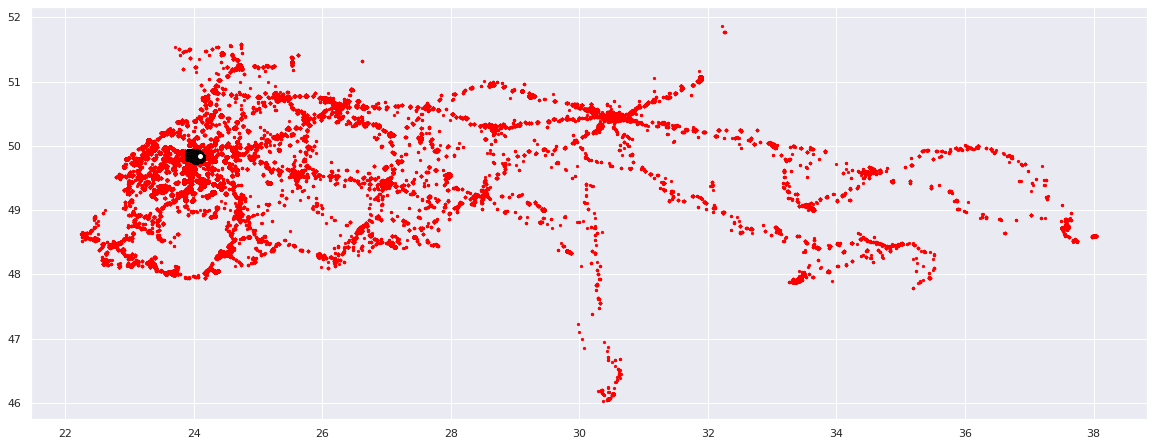

In [45]:
#define Lviv borders with black
base = points.plot(marker='o', color='red', markersize=5, figsize=(20, 15))
geo_df.plot(ax=base, color='white', edgecolor='black')

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


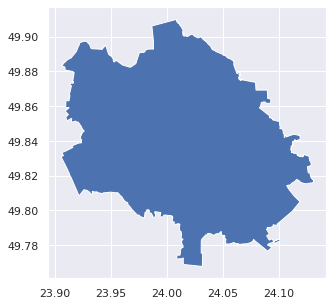

In [52]:
#another Lviv bordes visualization
polygon_lviv = Polygon(zip(geojson['lat'], geojson['lon']))
crs = {'init': 'epsg:4326'}
polygon = geopandas.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_lviv])       
polygon.plot(figsize=(15,5));

**User Routes**

The dataset contains data on the routes of subscribers (from a dataset with transactions, the keys are the same) between districts in 2019. Moving means that the subscriber before the start of the trip and at the end of the trip was in acc. area for more than 3 hours.


In [13]:
user_routes = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lviv/user_routes_Lviv.csv.gz', parse_dates = [1,3,5], dtype={'start_area_id':'int', 'finish_area_id':'int'})
print(user_routes.shape)     
user_routes.head()

(487055, 6)


,user_id,start_time,start_area_id,finish_time,finish_area_id,hmonth
0,113005,2019-06-03 06:00:00,58,2019-06-03 09:00:00,228,2019-06-01
1,113005,2019-06-03 13:00:00,228,2019-06-03 16:00:00,120,2019-06-01
2,113005,2019-06-05 07:00:00,120,2019-06-05 08:00:00,492,2019-06-01
3,113005,2019-06-05 18:00:00,492,2019-06-05 19:00:00,120,2019-06-01
4,113005,2019-06-07 11:00:00,120,2019-06-07 14:00:00,204,2019-06-01


**User transactions**

Dataset with transactions contains data with all transactions of subscribers for a calendar month. At the same time, for each city, subscribers were selected who do not live in it, but had at least 1 transaction in the city during the month.

In [14]:
transactions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lviv/user_transactions_Lviv.csv.gz', parse_dates = [1], names = ['user_id','event_dt','lat','lon'], skiprows = 1)
print(transactions.shape)     
transactions.head()

(15747791, 4)


,user_id,event_dt,lat,lon
0,135628,2020-09-28 11:12:40,49.545593,25.601088
1,125848,2020-09-17 00:07:46,49.402450,26.992640
2,135628,2020-09-28 21:13:05,49.554040,25.623373
3,125848,2020-09-17 12:14:10,49.402450,26.992640
4,135628,2020-09-30 10:54:05,49.554040,25.623373


In [15]:
#latitude and longtitude should be swiped, original data has a mistake.
transactions['lat_temp'] = transactions['lat'].astype('float')
transactions['lat'] = transactions['lon'].astype('float')
transactions['lon'] = transactions['lat_temp'].astype('float')
transactions.drop('lat_temp', axis = 1, inplace = True)

**Define day time and day of the week for each transaction.**

In [17]:
#is_day - if time between 06:00-20:00
six_h = dt.datetime.strptime('06:00:00', '%H:%M:%S').time()
twenty_h = dt.datetime.strptime('20:00:00', '%H:%M:%S').time()

In [18]:
transactions.loc[:,'time'] = transactions['event_dt'].dt.time
#is weekend - if it was Saturday or Sunday
transactions.loc[:,'is_weekend'] = transactions['event_dt'].dt.dayofweek.map({0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1})
transactions.loc[:,'is_day'] = transactions['time'].apply(lambda x: 1 if (x > six_h) & (x < twenty_h) else 0)

In [55]:
transactions.head()

,user_id,event_dt,lat,lon,time,is_weekend,is_day
0,135628,2020-09-28 11:12:40,25.601088,49.545593,11:12:40,0,1
1,125848,2020-09-17 00:07:46,26.992640,49.402450,00:07:46,0,0
2,135628,2020-09-28 21:13:05,25.623373,49.554040,21:13:05,0,0
3,125848,2020-09-17 12:14:10,26.992640,49.402450,12:14:10,0,1
4,135628,2020-09-30 10:54:05,25.623373,49.554040,10:54:05,0,1


**Re-define as Pyspark dataframe**

In [53]:
file_location = "/content/drive/MyDrive/Colab Notebooks/lviv/final/transactions_upd.csv"
file_type = "csv"
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

transaction_df = spark.read.format(file_type) \
          .option("inferSchema", infer_schema) \
          .option("header", first_row_is_header) \
          .schema(transaction_schema)\
          .option("sep", delimiter) \
          .load(file_location)

In [54]:
transaction_df.show()

+-----+-------+-------------------+------------------+------------------+-------------------+----------+------+
|index|user_id|           event_dt|               lat|               lon|               time|is_weekend|is_day|
+-----+-------+-------------------+------------------+------------------+-------------------+----------+------+
|    0| 135628|2020-09-28 11:12:40|         25.601088|         49.545593|2021-01-29 11:12:40|         0|     1|
|    1| 125848|2020-09-17 00:07:46|          26.99264|          49.40245|2021-01-29 00:07:46|         0|     0|
|    2| 135628|2020-09-28 21:13:05|         25.623373|          49.55404|2021-01-29 21:13:05|         0|     0|
|    3| 125848|2020-09-17 12:14:10|          26.99264|          49.40245|2021-01-29 12:14:10|         0|     1|
|    4| 135628|2020-09-30 10:54:05|         25.623373|          49.55404|2021-01-29 10:54:05|         0|     1|
|    5| 125848|2020-09-02 09:41:29|         26.953712|49.416779999999996|2021-01-29 09:41:29|         0|

**Define transactions from Lviv only**

In [ ]:
# do not re-use, data saved to 'is_lviv.csv'
points_in_lviv = []
for i,j in transactions[['lat', 'lon', 'event_dt', 'user_id']].iterrows():
  p = Point(j[0], j[1])
  if p.within(polygon_lviv):
    points_in_lviv.append([j[0], j[1], j[2], int(j[3]), 1])

is_lviv = pd.DataFrame(points_in_lviv, columns = ['lat', 'lon', 'event_dt', 'user_id', 'is_lviv'])
#is_lviv.to_csv('/content/drive/MyDrive/Colab Notebooks/lviv/final/is_lviv.csv')

In [24]:
is_lviv_pd = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lviv/final/is_lviv.csv')
is_lviv_pd.drop('Unnamed: 0', axis = 1, inplace = True)

In [25]:
is_lviv_pd

,lat,lon,event_dt,user_id,is_lviv
0,23.930510,49.864390,2020-09-25 07:51:55,135628,1
1,23.933480,49.828630,2020-09-25 07:51:14,135628,1
2,24.102741,49.842340,2020-09-26 23:05:09,125848,1
3,24.033490,49.837326,2020-09-26 16:03:56,143723,1
4,24.028100,49.836693,2020-09-26 16:06:47,143723,1
...,...,...,...,...,...
1561281,23.965063,49.829872,2020-09-14 15:52:24,131258,1
1561282,23.960436,49.828686,2020-09-22 03:21:36,131258,1
1561283,23.960436,49.828686,2020-09-22 02:51:36,131258,1
1561284,23.966090,49.829880,2020-09-14 09:57:45,131258,1


**Re-define dataframe as Pyspark Dataframe**

In [26]:
is_lviv = StructType([
    StructField("Unnamed: 0", StringType(), True),        
    StructField("lat2", DoubleType(), True),
    StructField("lon2", DoubleType(), True),
    StructField("event_dt2", TimestampType(), True),
    StructField("user_id2", IntegerType(), True),
    StructField("is_lviv", IntegerType(), True),
    ])

transaction_schema = StructType([
    StructField("index", IntegerType(), True),
    StructField("user_id", IntegerType(), True),        
    StructField("event_dt", TimestampType(), True),
    StructField("lat", DoubleType(), True),
    StructField("lon", DoubleType(), True),
    StructField("time", TimestampType(), True),
    StructField("is_weekend", IntegerType(), True),
    StructField("is_day", IntegerType(), True)])

In [29]:
file_location = "/content/drive/MyDrive/Colab Notebooks/lviv/final/is_lviv.csv"
file_type = "csv"
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

is_lviv_df = spark.read.format(file_type) \
          .option("inferSchema", infer_schema) \
          .option("header", first_row_is_header) \
          .schema(is_lviv)\
          .option("sep", delimiter) \
          .load(file_location)

In [30]:
is_lviv_df.count()

1561286

**Combine dataframes on user_id and event_id**

In [58]:
cond = (transaction_df.user_id == is_lviv_df.user_id2) & (transaction_df.event_dt == is_lviv_df.event_dt2) 
concated_df = transaction_df.join(is_lviv_df, cond, 'left')
concated_df

DataFrame[index: int, user_id: int, event_dt: timestamp, lat: double, lon: double, time: timestamp, is_weekend: int, is_day: int, Unnamed: 0: string, lat2: double, lon2: double, event_dt2: timestamp, user_id2: int, is_lviv: int]

In [59]:
drop_list = ['Unnamed: 0','lat2','lon2','event_dt2','user_id2']
#drop unnecessary columns
concated_df = concated_df.drop(*drop_list)
concated_df = concated_df.fillna({'is_lviv':0})

In [60]:
windowSpec = Window.partitionBy("user_id").orderBy('event_dt')
#define next event
concated_df = concated_df.withColumn('next_event', lead('event_dt', 1).over(windowSpec))
#find time difference between events
concated_df = concated_df.withColumn('Time_diff', (col('next_event').cast(LongType()) - col('event_dt').cast(LongType())))
#define if time difference is just 1h or less and was from Lviv
concated_df = concated_df.withColumn('1h', when((concated_df.Time_diff < 5000) & (concated_df.is_lviv == 1), 1).otherwise(0))

In [61]:
concated_df.show()

+--------+-------+-------------------+---------+---------+-------------------+----------+------+-------+-------------------+---------+---+
|   index|user_id|           event_dt|      lat|      lon|               time|is_weekend|is_day|is_lviv|         next_event|Time_diff| 1h|
+--------+-------+-------------------+---------+---------+-------------------+----------+------+-------+-------------------+---------+---+
|12305607| 101627|2020-09-01 07:25:45|24.049915|49.766483|2021-01-29 07:25:45|         0|     1|      0|2020-09-01 07:28:39|      174|  0|
|12305090| 101627|2020-09-01 07:28:39|24.040401|49.771736|2021-01-29 07:28:39|         0|     1|      0|2020-09-01 07:28:40|        1|  0|
|12305821| 101627|2020-09-01 07:28:40|24.040401|49.771736|2021-01-29 07:28:40|         0|     1|      0|2020-09-01 07:30:40|      120|  0|
|12305347| 101627|2020-09-01 07:30:40|24.049915|49.766483|2021-01-29 07:30:40|         0|     1|      0|2020-09-01 07:30:41|        1|  0|
|12304145| 101627|2020-09-0

**Get some statistics: how many transactions was from Lviv, was it in a day, was it weekend or not, total number of each user transactions and how many of them least less then 1h.**

In [62]:
grouped_df =  concated_df.groupby('user_id').agg(sum('is_lviv'), sum('is_day'), sum('is_weekend'), count('lat'), sum('1h'))

In [63]:
grouped_df.show()

+-------+------------+-----------+---------------+----------+-------+
|user_id|sum(is_lviv)|sum(is_day)|sum(is_weekend)|count(lat)|sum(1h)|
+-------+------------+-----------+---------------+----------+-------+
| 101627|          97|       2561|            856|      2802|     94|
| 104656|         434|       1299|            413|      1619|    427|
| 108460|          22|       3452|            815|      3832|     22|
| 109172|          56|       7035|           1343|      8309|     56|
| 116259|         403|       6025|           1700|      7436|    397|
| 118185|          94|       1875|            669|      2857|     94|
| 120861|           9|        408|            104|       464|      8|
| 122484|           9|        216|             61|       229|      4|
| 124411|          73|       3979|           1799|      4868|     73|
| 126191|          11|       1681|            570|      2452|     11|
| 127109|           9|       1718|            740|      2324|      8|
| 130995|         55

In [64]:
grouped_df.count()

5597

In [ ]:
#convert to Pandas to save as csv
#temp = grouped_df.toPandas()
#temp.to_csv('/content/drive/MyDrive/Colab Notebooks/lviv/final/final.csv')

In [65]:
transactions_grouped = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lviv/final/final.csv', skiprows = 1, names = ['Unnamed: 0',	'user_id', 'transactions_lviv',
                                                                                                      'is_daytime',	'is_weekend',
                                                                                                      'total_transactions', 'hours_in_lviv'])
transactions_grouped.drop('Unnamed: 0', axis = 1, inplace = True)

In [72]:
transactions_grouped.head(10)

,user_id,transactions_lviv,is_daytime,is_weekend,total_transactions,hours_in_lviv
0,101627,97,2561,856,2802,94
1,104656,434,1299,413,1619,427
2,108460,22,3452,815,3832,22
3,109172,56,7035,1343,8309,56
4,116259,403,6025,1700,7436,397
5,118185,94,1875,669,2857,94
6,120861,9,408,104,464,8
7,122484,9,216,61,229,4
8,124411,73,3979,1799,4868,73
9,126191,11,1681,570,2452,11


Hours in Lviv is the wrong metric, it does not make that sense. 

### Clusterization

Code for clusterization used from previous task

In [67]:
import os
import math
import matplotlib.pyplot as plt
import sklearn
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, MiniBatchKMeans, AgglomerativeClustering, KMeans
from scipy.stats import mode, itemfreq
from scipy.spatial.distance import cdist 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import metrics 
import numpy as np 

%matplotlib inline

In [119]:
def pefrom_clustering(data, n_clusters = 3, random_state = 0):
  kmeans = KMeans(
      n_clusters = n_clusters,
      random_state = random_state)

  return kmeans.fit(data)

In [120]:
def get_standartized_data(df):
  return StandardScaler().fit_transform(df[[
  'transactions_lviv',
  'is_daytime',
  'is_weekend',
  'total_transactions',]].values)

In [121]:
transactions_grouped_stand = get_standartized_data(transactions_grouped)
kmeans_19 = pefrom_clustering(transactions_grouped_stand)

In [122]:
transactions_grouped['labels'] = kmeans_19.labels_
transactions_grouped.groupby('labels')[['labels']].count()

,labels
labels,
0,3618
1,1683
2,296


In [123]:
#define best number of clusters
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(transactions_grouped_stand)
    Sum_of_squared_distances.append(km.inertia_)

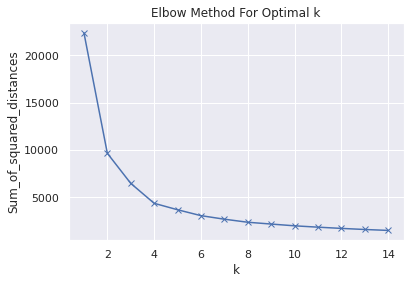

In [124]:
plt.plot(K, Sum_of_squared_distances, 'bx-',)
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

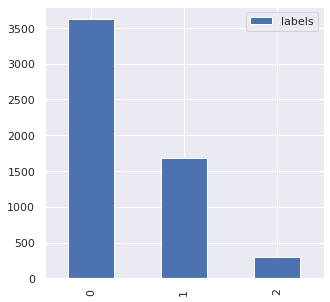

In [125]:
clusters = transactions_grouped.groupby('labels', as_index = False)[['labels']].count()
clusters.plot.bar(figsize = (5, 5))

In [128]:
transactions_0 = transactions_grouped[transactions_grouped['labels'] == 0]
transactions_1 = transactions_grouped[transactions_grouped['labels'] == 1]
transactions_2 = transactions_grouped[transactions_grouped['labels'] == 2]

In [129]:
def feature_compare_hist(clusters, mean = True):
    def map_cluster(cluster, feature, mean = True):
      return cluster[feature].mean() if mean else cluster[feature].mode()[0]

    col_title = 'mean:' if mean else 'mode:'
    pd.DataFrame({
      f'{col_title} how many times was in lviv': [map_cluster(cluster, 'transactions_lviv', mean) for cluster in clusters],
      f'{col_title} how many times event was in day time': [map_cluster(cluster, 'is_daytime', mean) for cluster in clusters],
      f'{col_title} how many times event was on weekend': [map_cluster(cluster, 'is_weekend', mean) for cluster in clusters],
      f'{col_title} total count of events': [map_cluster(cluster, 'total_transactions', mean) for cluster in clusters]
  }, index = [f'{i} Segment' for i in range(len(clusters))]).plot(kind = 'barh', figsize = (20, 10))

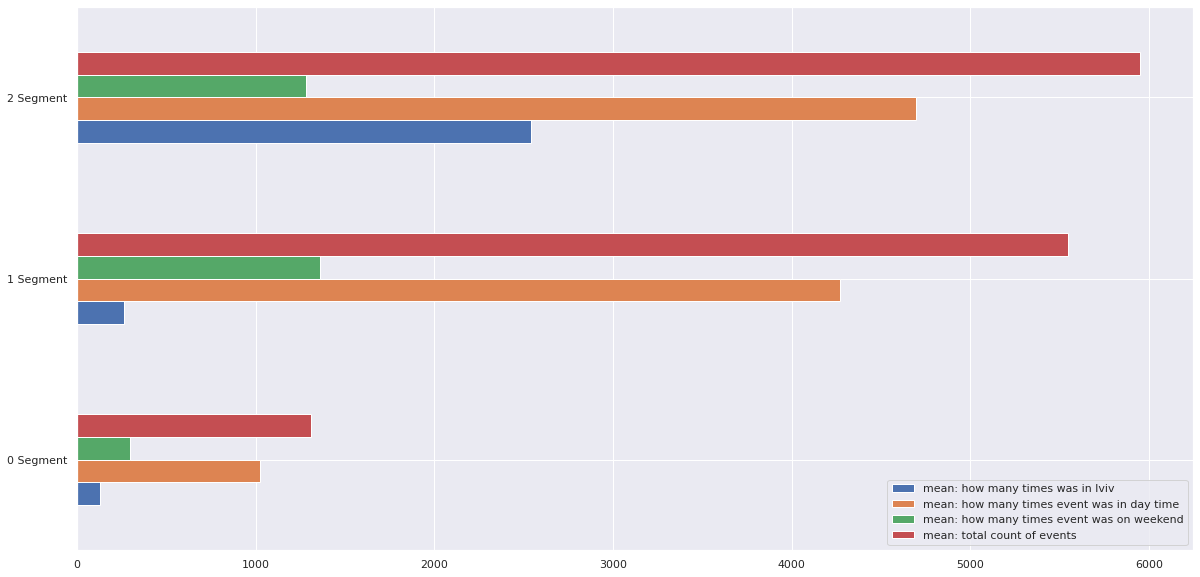

In [130]:
feature_compare_hist([transactions_0, transactions_1, transactions_2], mean = True)

**Purposes of the visit:**

**Transit** - the larger (65%) - 0 cluster, it includes subscribers who did not make a lot of transactions in a month, and no more than 15% of them were in Lviv, also these subscribers made most transactions were not on the weekend.

**Tourism, multi-transit** - 1 cluster, it includes people with a large number of transactions and a small number of them in Lviv, which separates them from those working in the city.  In addition, about 25% of transactions occurred on weekends.

**Work** - is the smallest  - 2 cluster, it characterized by the largest number of transactions, a significant part of which ~ 40% falls in Lviv and on weekdays. 